# ``graspologic`` demo

In [ ]:
!pip install graspologic --pre

In [1]:
import graspologic

graspologic.__version__

'3.0.0'

## Loading some data

In [2]:
from pathlib import Path

data_path = Path('./data')
dataset = 'maggot_brain'
dataset_path = data_path / dataset

In [3]:
from graspologic.datasets import load_drosophila_right

A, labels = load_drosophila_right(return_labels=True)

## Network embedding

Generally speaking, an **embedding** refers to some technique which takes a network (or
networks as we'll see later) and converts it to a representation in some vector space.
Often, this is a Euclidean vector space, and in that space each vector represents a
single node in the network. We'll focus on this case for now.

### Why embed networks? 
- Embedding networks can be viewed as fitting the parameters of statistical models, 
  for example, a random dot product graph.
- Embeddings can be useful for creating visualizations of networks. 
- Embeddings allow us to use a wide range of general machine learning techniques and
  make them applicable for networks.

In `graspologic`, this functionality is implemented under the `AdjacencySpectralEmbed` 
estimator class. There are a few extra bells and whistles, but the core algorithm is
exactly the same as the one above - just an SVD of the adjacency matrix. Note that this
algorithm also works well for weighted networks, but we lose some of the interpretation
of the approximation matrix as a matrix of probabilities.

In [4]:
from graspologic.embed import AdjacencySpectralEmbed

ase = AdjacencySpectralEmbed()

X, Y = ase.fit_transform(A)

`ase.fit_transform()` returns a tuple `(X, Y)` if the graph is directed. Otherwise, it
just returns `X`.

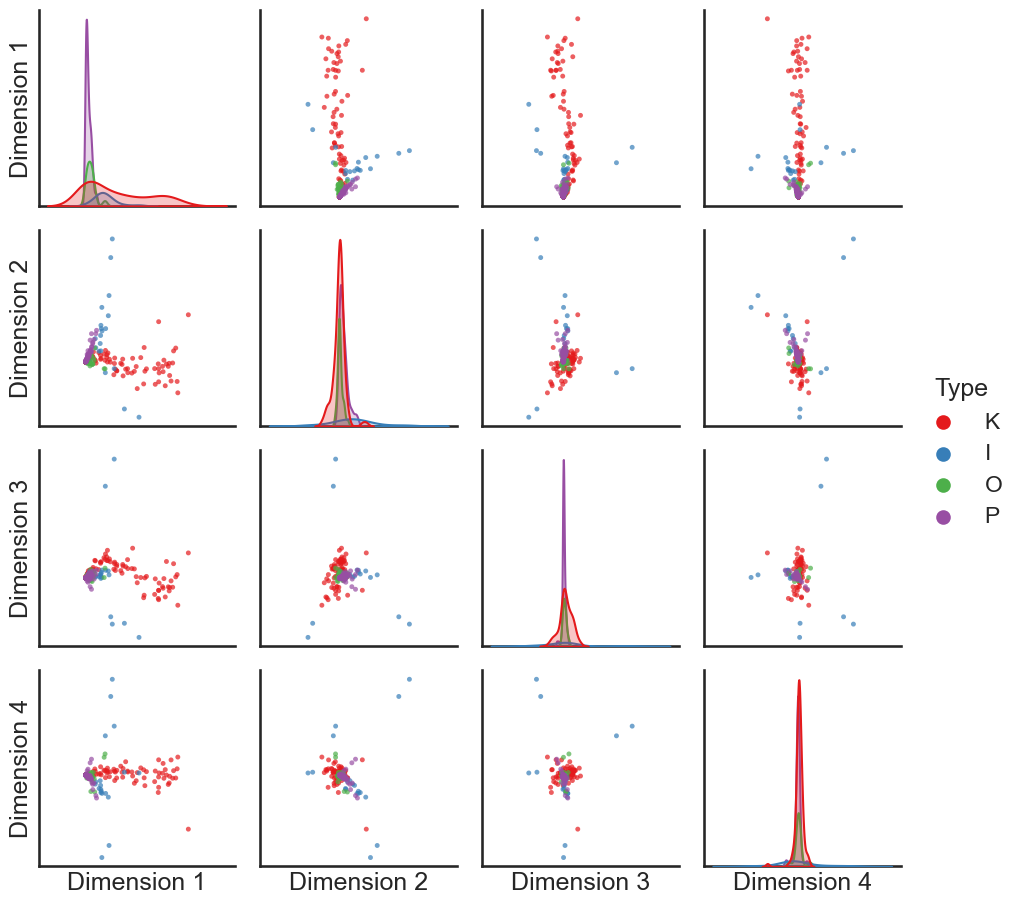

In [5]:
from graspologic.plot import pairplot

pairplot(X, labels=labels)

For spectral methods on weighted networks, we often find it useful to do an operation 
called "pass-to-ranks." This essentially ranks each edge from smallest to largest weight,
then replaces the edge weight by a normalized version of the rank. It has the effect of
putting edges closer to the same scale.

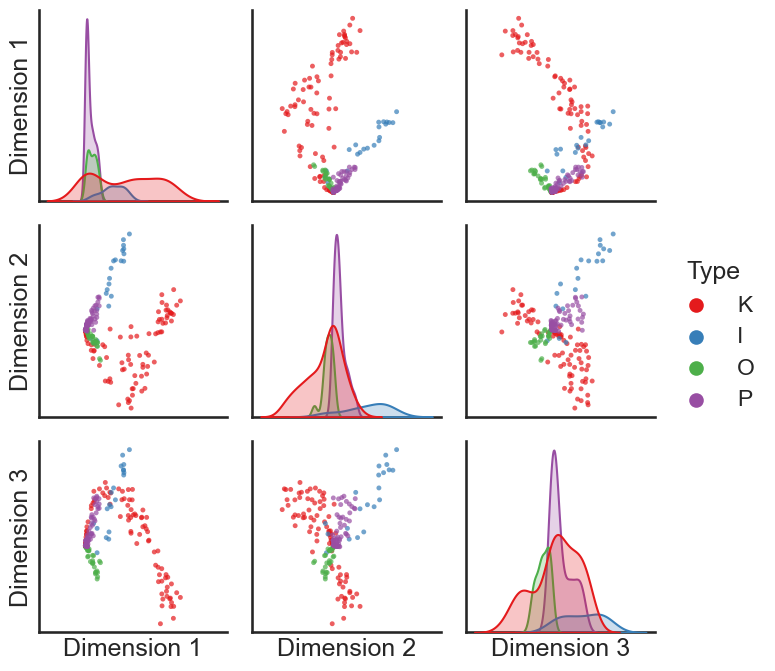

In [6]:
from graspologic.utils import pass_to_ranks

ase = AdjacencySpectralEmbed()

A_ptr = pass_to_ranks(A)

X, Y = ase.fit_transform(A_ptr)

pairplot(X, labels=labels)

For some applications, we don't care about having a separate representation for each 
node in terms of its inputs and outputs. We can simply concatenate the "out" and "in" 
representations. You can do this yourself, or we can specify this behavior in `graspologic`.

In [7]:
Z = AdjacencySpectralEmbed(concat=True).fit_transform(A_ptr)
Z.shape

(213, 6)

We can also embed a matrix in sparse format, which will usually be faster for sparse 
networks with more than a small number of nodes.

In [ ]:
from scipy.sparse import csr_matrix

Z = AdjacencySpectralEmbed(concat=True).fit_transform(csr_matrix(A_ptr))
Z.shape

## Graph matching

## Permutations

To start to understand graph matching, we first need to understand permutations and 
permutation matrices.

A [**permutation**](https://en.wikipedia.org/wiki/Permutation) can be thought of as a
specific ordering or arrangement of some number of objects. 

```{admonition} Question
:class: tip

How many permutations are there of $n$ objects?
```

Permutations, for us, will be represented by [**permutation matrices**](https://en.wikipedia.org/wiki/Permutation_matrix).
A permutation matrix is $n \times n$, with all zeros except for $n$ 1s. More specifically, each row and column has exactly one 1 in it. Let's look at
what a permutation matrix times a vector looks like.

```{figure} https://en.wikipedia.org/wiki/Permutation_matrix#/media/File:Permutation_matrix;_P_*_column.svg
:width: 200px

A permutation matrix multiplied by a vector. The red elements of the matrix indicate the 
1s. Image from [Wikipedia](https://en.wikipedia.org/wiki/Permutation_matrix).
```

So, we see that if we look at the permutation matrix, the *row index* represents the 
index of the new position of object $i$. The *column index* represents the original
position of an object. So, if we have a 1 at position $(1, 4)$, that means the first
object was the fourth object in the original arangement.

Note that this also works for matrices: each column of a matrix $A$ would be permuted
the same way as the vector in the example above. So, we can think of 

$$PA$$

as permuting the *rows* of the matrix $A$.

Note that post-multiplication by the matrix $P$ works the opposite way (try it out 
yourself if you don't see this, or refer to the Wikipedia article). For this reason, if
we wanted to permute the columns of $A$ in the same way, we'd have to do

$$AP^T$$

```{admonition} Question
:class: tip

How can we permute the rows *and* columns of the matrix $A$ in the same way? Why do 
we care about this for networks?
```

## Graph matching problem

Why do we care about permutations for the problem of [**graph matching**](https://en.wikipedia.org/wiki/Graph_matching)?
Graph matching refers to the problem of finding a mapping between the nodes of one graph ($A$)
and the nodes of some other graph, $B$. For now, consider the case where the two networks
have exactly the same number of nodes. Then, this problem amounts to finding a *permutation* 
of the nodes of one network with regard to the nodes of the other. Mathematically, we
can think of this as comparing $A$ vs. $P B P^T$. 

```{note}
You can think of graph matching as a more general case of the [**graph isomorphism problem**](https://en.wikipedia.org/wiki/Graph_isomorphism_problem).

In the case of graph matching, we don't assume that the graphs must be exactly the same
when matched, while for the graph isomorphism problem, we do.
```

How can we measure the quality of this alignment between two networks, given what 
we've talked about so far? Like when we talked about approximating matrices in the [embeddings](embeddings.ipynb)
section, one natural way to do this is via the Frobenius norm of the difference. 

$$e(P) = \|A - PBP^T\|_F$$

```{admonition} Question
:class: tip

In words, what is this quantity $e(P)$ measuring with respect to the edges of two
unweighted networks?
```

We can use this same definition above for any type of network: unweighted or weighted, 
directed or undirected, with or without self-loops.

```{figure} ./images/network-matching-explanation.png
Diagram explaining graph matching.
```

## Solving the graph matching problem

If you are curious...

Many solutions for the problem above have been proposed - note that all of these are 
approximate solutions, and they tend to scale fairly poorly (in the number of nodes)
compared to some of the other algorithms we have discussed so far. Nevertheless, a lot 
of progress has been made. I'm just going to focus on one family of algorithms based
on the work of {cite:t}`vogelstein2015fast`.

As we discussed when looking at the spectral method for maximizing modularity, we have a
discrete problem, but we'd like to use continuous optimization tools where we can take
gradients. To make this possible, the Fast Approximate Quadradic (FAQ) method first 
relaxes the constraint that $P$ be a permutation matrix. Via the Birkhoff-von Neumann theorem, it can be shown that the [convex hull](https://en.wikipedia.org/wiki/Convex_hull)
of the permutation matrices is the set of [**doubly stochastic matrices**](https://en.wikipedia.org/wiki/Doubly_stochastic_matrix). A doubly stochastic matrix just has row 
and columns sums equal to 1, but does not necessarily have to have all nonzero elements
equal to 1. This theorem is just saying that if I take a weighted average of any two 
permutation matrices, the row and columns sums of the result must be 1.

It can be shown that minimizing our $e(P)$ above is equivalent to 

$$\min_P -\text{trace}(APB^T P^T)$$

```{note}
The [**quadratic assignment problem**](https://en.wikipedia.org/wiki/Quadratic_assignment_problem) can be written as $\min_P \text{trace}(APB^T P^T)$ - since these are just a sign flip away, any algorithm which solves one can be
easily used to solve the other.
```

Calling our doubly stochastic matrices $D$, we now have 

$$\min_D -\text{trace}(ADB^T D^T)$$

Given this relaxation, we can now begin to take gradients in our space of matrices. I won't go into every detail, but the algorithm we end up using is 
something like:
1. Start with some initial position - note that this position is a doubly stochastic matrix.
2. Compute the gradient of the expression above with respect to $D$. This gives us our "step direction."
3. Compute a step size (how far to go in that direction in the space of matrices) by searching over the line between our current position and the one computed in 2.
4. Update our position based on 3.
5. Repeat 2.-4. until some convergence criterion is reached.
6. Project back to the set of permutation matrices.